# 세포 전자현미경을 통한 세포 이미지의 segmentation w/UNET 학습 및 테스트
* isbi 2012 EM (Electron Microscopy) dataset과 UNET을 이용한 segmentation.
* 해당 jupyter 포함내용
  * train, evaluation (single GPU or multi GPUs 선택가능)
  * visualization sample
  * output save & visualization
  * jupyter tensorboard

In [4]:
import os
import numpy as np
import time
import pandas as pd

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter    # tensorboard pip 설치시 이용가능

from model import UNet
from dataset import *
from util import *

import matplotlib.pyplot as plt

from torchvision import transforms, datasets



to do:
1. ~~mode 제거~~
2. ~~dataset visualization for input~~
1. ~~dataset visualization for output~~
3. display.py 정리 (나중에)
4. ~~tensorboard 실행~~
5. ~~시간 체크 저장~~
6. ~~멀티 gpu셋팅~~
7. github 정리
  * 현 github 정리
  * simple DNN 정리

## st1. Setting custom

In [5]:
lr = 1e-2
batch_size = 2
num_epoch = 10 # 300  

data_dir = "datasets"
ckpt_dir = "out/checkpoint"
log_dir = "out/log"
result_dir = "out/result"

mode = "train"    # train or test
train_continue = "off"
multi_gpu = True
gpu_idx = "1,2"    # GPU 환경일 때 이용할 GPU설정 (GPU 환경 아닐 경우 사용안함)

## st2. environment setting & dataset loading

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if torch.cuda.is_available():
    os.environ['CUDA_VISIBLE_DEVICES'] = gpu_idx
    
print("learning rate: %.4e" % lr)
print("batch size: %d" % batch_size)
print("number of epoch: %d" % num_epoch)
print("data dir: %s" % data_dir)
print("ckpt dir: %s" % ckpt_dir)
print("log dir: %s" % log_dir)
print("result dir: %s" % result_dir)

## dataset for training
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), RandomFlip(), ToTensor()])

dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, num_workers=8)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
# tensorboard외 loss 진행사항을 출력하기 위한 변수
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

# batch로 인한 training 수를 확인하기 위한 변수
num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)


learning rate: 1.0000e-02
batch size: 2
number of epoch: 10
data dir: datasets
ckpt dir: out/checkpoint
log dir: out/log
result dir: out/result


### 2-1. dataset visualization

In [7]:
def tensor_to_imgnp_labelnp(img_tensor, label_tensor):
    """
    img, label : tensor -> np & (C, H, W) -> (H, W, C) & sqeeze dim
    img: + denormalizing
    """
    
    fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(1, 2, 0) # tensor to np & (c, h, w) -> (h, w, c)
    fn_denorm = lambda x, mean, std: (x * std) + mean    # norm val -> denormalization

    label = fn_tonumpy(label_tensor).squeeze()     # channel 삭제
    input = fn_tonumpy(fn_denorm(img_tensor, mean=0.5, std=0.5)).squeeze()
    
    return input, label

def draw_img_label(img_np, label_np, cmap='color', size=None, ratio=None, img_title=None, label_title=None):
    # cmap에 따라 컬러 or 흑백 이미지 그림
    %matplotlib inline
    
    if type(img_np) != np.ndarray:
        img_np = read_img_to_np(img_np, cmap=cmap)
        label_np = read_img_to_np(label_np, cmap=cmap)
    
    print(f"input shape: {img_np.shape}")
    print(f"label shape: {label_np.shape}")
    
    if size:
        plt.figure(figsize=size)
    elif ratio:
        plt.figure(figsize=(8*ratio, 8*ratio))
    else:
        plt.figure()
    
    
    plt.subplot(121)
    plt.imshow(img_np, cmap=cmap)
    if not img_title:
        img_title = "input"
    plt.title(img_title, fontsize=15)

    
    plt.subplot(122)
    plt.imshow(label_np, cmap=cmap)
    if not label_title:
        label_title = "label"
    plt.title(label_title, fontsize=15)
    
    plt.show()
    
    
def draw_img_label_output(
    img_np, label_np, output_np, cmap='color', size=None, ratio=None, 
    img_title=None, label_title=None, output_title=None
):
    # cmap에 따라 컬러 or 흑백 이미지 그림
    %matplotlib inline
    
    if type(img_np) != np.ndarray:
        img_np = read_img_to_np(img_np, cmap=cmap)
        label_np = read_img_to_np(label_np, cmap=cmap)
        output_np = read_img_to_np(output_np, cmap=cmap)
    
    print(f"input shape: {img_np.shape}")
    print(f"label shape: {label_np.shape}")
    print(f"output shape: {output_np.shape}")
    
    if size:
        plt.figure(figsize=size)
    elif ratio:
        plt.figure(figsize=(8*ratio, 8*ratio))
    else:
        plt.figure()
    
    
    plt.subplot(131)
    plt.imshow(img_np, cmap=cmap)
    if not img_title:
        img_title = "input"
    plt.title(img_title, fontsize=15)

    
    plt.subplot(132)
    plt.imshow(label_np, cmap=cmap)
    if not label_title:
        label_title = "label"
    plt.title(label_title, fontsize=15)
    
    plt.subplot(133)
    plt.imshow(output_np, cmap=cmap)
    if not output_title:
        output_title = "output"
    plt.title(output_title, fontsize=15)
    
    plt.show()

input shape: (512, 512)
label shape: (512, 512)


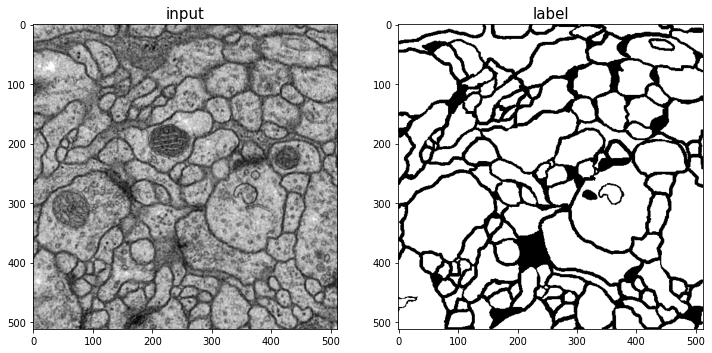

In [8]:
sample = next(iter(dataset_train))
input, label = sample['input'], sample['label']
input, label = tensor_to_imgnp_labelnp(input, label)
draw_img_label(input, label, cmap='gray', size=(12, 12))

## st3. Network

In [9]:
## 네트워크 생성하기

# multi gpu setting
if torch.cuda.is_available() and multi_gpu:
    net = UNet()
    net = nn.DataParallel(net).to(device)
else:
    net = UNet().to(device)

## 손실함수 정의하기 - binary classification
fn_loss = nn.BCEWithLogitsLoss().to(device)

## Optimizer 설정하기
optim = torch.optim.Adam(net.parameters(), lr=lr)

## 그밖에 부수적인 functions 설정하기
fn_tonumpy = lambda x: x.to('cpu').detach().numpy().transpose(0, 2, 3, 1) # tensor to np
fn_denorm = lambda x, mean, std: (x * std) + mean    # norm val -> denormalization (tensorboard 적용)
fn_class = lambda x: 1.0 * (x > 0.5)    # binary class로 변경(softmax 개념) (tensorboard 적용)

## Tensorboard 를 사용하기 위한 SummaryWriter 설정
writer_train = SummaryWriter(log_dir=os.path.join(log_dir, 'train'))
writer_val = SummaryWriter(log_dir=os.path.join(log_dir, 'val'))

net

DataParallel(
  (module): UNet(
    (enc1_1): Sequential(
      (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc1_2): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (enc2_1): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (enc2_2): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    

## st4. Training

In [10]:
VERBOSE = 2     # 1: all print / 2: epoch print / False: only time print


st_epoch = 0
epoch_time_list = list()

if train_continue == "on":
    # 특히 colab에서 session 재시작의 경우 문제가 생길 수 있으므로. 다음과 같이 설정
    net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

for epoch in range(st_epoch + 1, num_epoch + 1):
    net.train()
    loss_arr = []

    print('-------------- epoch {} ----------------'.format(epoch)) 
    since = time.time() 
    
    for batch, data in enumerate(loader_train, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # backward pass
        optim.zero_grad()

        loss = fn_loss(output, label)
        loss.backward()

        optim.step()

        # 손실함수 계산
        # 내부 format 궁금하네
        loss_arr += [loss.item()]

        if VERBOSE == 1:
            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))

        # Tensorboard 저장하기
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        # Tensorboard 에 img를 저장
        writer_train.add_image('label', label, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('input', input, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')
        writer_train.add_image('output', output, num_batch_train * (epoch - 1) + batch, dataformats='NHWC')

    # epoch당 Tensorboard에 loss 저장
    writer_train.add_scalar('loss', np.mean(loss_arr), epoch)

    # epoch당 validation 시작
    with torch.no_grad():   # backpropa block
        net.eval()          # network에 validation 명시
        loss_arr_val = []

        for batch, data in enumerate(loader_val, 1):
            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # 손실함수 계산하기
            loss = fn_loss(output, label)

            loss_arr_val += [loss.item()]

            if VERBOSE == 1:
                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                      (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))

            # Tensorboard 저장하기
            label = fn_tonumpy(label)
            input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
            output = fn_tonumpy(fn_class(output))

            writer_val.add_image('label', label, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('input', input, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')
            writer_val.add_image('output', output, num_batch_val * (epoch - 1) + batch, dataformats='NHWC')

    writer_val.add_scalar('loss', np.mean(loss_arr_val), epoch)
    
    if VERBOSE:
        print(f"EPOCH {epoch} / {num_epoch} | TRAIN mean.LOSS {np.mean(loss_arr):.3f}   VAL: mean.LOSS {np.mean(loss_arr_val):.3f}")
    
    time_elapsed = time.time() - since  
    print('Completed in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    epoch_time_list.append(time_elapsed)

    if epoch % 50 == 0:
        # 50 epoch당 모델 저장
        save(ckpt_dir=ckpt_dir, net=net, optim=optim, epoch=epoch)

# 학습 완료시 tensorboard closing
writer_train.close()
writer_val.close()

-------------- epoch 1 ----------------
EPOCH 1 / 10 | TRAIN mean.LOSS 0.395   VAL: mean.LOSS 1543.799
Completed in 0m 59s
-------------- epoch 2 ----------------
EPOCH 2 / 10 | TRAIN mean.LOSS 0.281   VAL: mean.LOSS 0.602
Completed in 0m 10s
-------------- epoch 3 ----------------
EPOCH 3 / 10 | TRAIN mean.LOSS 0.265   VAL: mean.LOSS 0.278
Completed in 0m 10s
-------------- epoch 4 ----------------
EPOCH 4 / 10 | TRAIN mean.LOSS 0.249   VAL: mean.LOSS 0.715
Completed in 0m 21s
-------------- epoch 5 ----------------
EPOCH 5 / 10 | TRAIN mean.LOSS 0.246   VAL: mean.LOSS 0.254
Completed in 0m 10s
-------------- epoch 6 ----------------
EPOCH 6 / 10 | TRAIN mean.LOSS 0.240   VAL: mean.LOSS 0.252
Completed in 0m 12s
-------------- epoch 7 ----------------
EPOCH 7 / 10 | TRAIN mean.LOSS 0.233   VAL: mean.LOSS 0.299
Completed in 0m 10s
-------------- epoch 8 ----------------
EPOCH 8 / 10 | TRAIN mean.LOSS 0.232   VAL: mean.LOSS 0.335
Completed in 0m 13s
-------------- epoch 9 --------------

In [11]:
# 시간 측정 테이블 저장

df = pd.DataFrame(epoch_time_list, columns=["vanillaUNet_model"])
df.to_csv("time_exp3.csv", index=False)
df.head()

,vanillaUNet_model
0,59.122838
1,10.194427
2,9.575867
3,20.747397
4,10.149341


## st5. Testing / Evaluation

In [12]:
## result dir 생성하기
if not os.path.exists(result_dir):
    os.makedirs(os.path.join(result_dir, 'png'))
    os.makedirs(os.path.join(result_dir, 'numpy'))

# dataset for validation
transform = transforms.Compose([Normalization(mean=0.5, std=0.5), ToTensor()])

dataset_test = Dataset(data_dir=os.path.join(data_dir, 'test'), transform=transform)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False, num_workers=8)

# 그밖에 부수적인 variables 설정하기
num_data_test = len(dataset_test)

num_batch_test = np.ceil(num_data_test / batch_size)

In [13]:
# TEST MODE (맨 마지막 model을 불러와서 evaluation 진행)
net, optim, st_epoch = load(ckpt_dir=ckpt_dir, net=net, optim=optim)

with torch.no_grad():
    net.eval()
    loss_arr = []

    for batch, data in enumerate(loader_test, 1):
        # forward pass
        label = data['label'].to(device)
        input = data['input'].to(device)

        output = net(input)

        # 손실함수 계산하기
        loss = fn_loss(output, label)

        loss_arr += [loss.item()]

        print("TEST: BATCH %04d / %04d | LOSS %.4f" %
              (batch, num_batch_test, np.mean(loss_arr)))

        # Tensorboard 저장하기
        label = fn_tonumpy(label)
        input = fn_tonumpy(fn_denorm(input, mean=0.5, std=0.5))
        output = fn_tonumpy(fn_class(output))

        for j in range(label.shape[0]):
            id = num_batch_test * (batch - 1) + j

            plt.imsave(os.path.join(result_dir, 'png', 'label_%04d.png' % id), label[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'input_%04d.png' % id), input[j].squeeze(), cmap='gray')
            plt.imsave(os.path.join(result_dir, 'png', 'output_%04d.png' % id), output[j].squeeze(), cmap='gray')

            np.save(os.path.join(result_dir, 'numpy', 'label_%04d.npy' % id), label[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'input_%04d.npy' % id), input[j].squeeze())
            np.save(os.path.join(result_dir, 'numpy', 'output_%04d.npy' % id), output[j].squeeze())

print("AVERAGE TEST: BATCH %04d / %04d | LOSS %.4f" %
      (batch, num_batch_test, np.mean(loss_arr)))

TEST: BATCH 0001 / 0002 | LOSS 0.2638
TEST: BATCH 0002 / 0002 | LOSS 0.2611
AVERAGE TEST: BATCH 0002 / 0002 | LOSS 0.2611


### 5-1 dataset visualization

In [14]:
input, label = sample['input'].to(device), sample['label']
input = input.to(device).unsqueeze(dim=0)
output = net(input)
print(output.shape)
input.squeeze(dim=0).shape

torch.Size([1, 1, 512, 512])


torch.Size([1, 512, 512])

input shape: (512, 512)
label shape: (512, 512)
output shape: (512, 512)


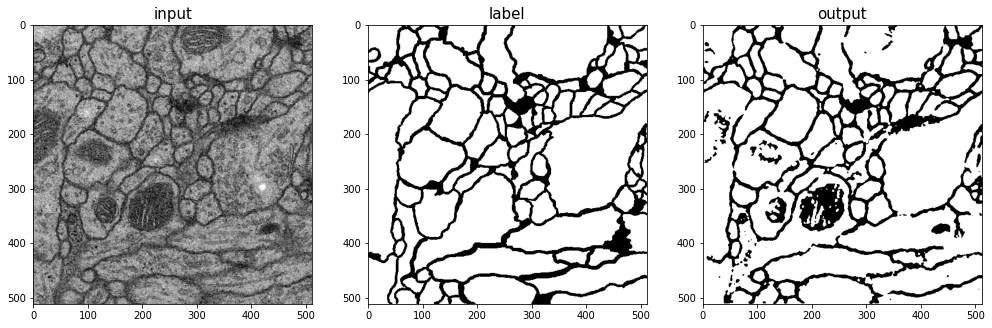

In [15]:
sample = next(iter(dataset_test))
input, label = sample['input'], sample['label']
input = input.to(device).unsqueeze(dim=0)  # B dim add

output = net(input)

output = fn_tonumpy(fn_class(output))
output = output.squeeze()
input = input.squeeze(dim=0)

input, label = tensor_to_imgnp_labelnp(input, label)
draw_img_label_output(input, label, output, cmap='gray', size=(17, 6))

# st 6. tensorboard check
* train, validation 만 저장함

## 6-1 이미지 수 계산

In [16]:
train_img_cnt = int(num_batch_train * num_epoch)
val_img_cnt = int(num_batch_val * num_epoch)

print(f"train batch 수: {num_batch_train} / val batch 수: {num_batch_val}")
print(f"loss 수: {num_epoch} epoch")
print(f"tenboard train imgs : {train_img_cnt} 장 / tb val imgs : {val_img_cnt} 장")

train batch 수: 12.0 / val batch 수: 2.0
loss 수: 10 epoch
tenboard train imgs : 120 장 / tb val imgs : 20 장


In [17]:
%load_ext tensorboard

In [18]:
# tensorboard --host=0.0.0.0 --logdir='/data/kehyeong/project/youtube-cnn-002-pytorch-unet/out/log'

# st Opt. remove output

In [19]:
# import shutil

# out_dir = './out'
# shutil.rmtree(out_dir)